# Analyse performances

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, brier_score_loss, roc_auc_score, average_precision_score, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from scipy.stats import ttest_ind
from statkit import decision

/home/WUR/katz001/miniconda3/envs/env_permit_gas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
target_rkz = "GAS_yes_no"
percentBoruta = 100
n_iter = 1000


''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/50_externalValidation"
resultsPath = f"{PATH}/results/50_externalValidation/{datasetTimepoint}/finetune"
dataPath = f"{PATH}/results/10_preprocessed/validation"

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/{datasetTimepoint}_{target}_validationData.csv", index_col=None, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())


''' 
Split
'''
X_val = data.drop(target_rkz, axis=1)
y_val = data[target_rkz]#.values

0.1 0.731984660706718
0.2 0.7500683957007614
0.3 0.758177192641122
0.4 0.7638004169416588
0.5 0.7655894260704734
0.6 0.7691545653437215
0.7 0.7725638737378879
0.8 0.7739320088157505
0.9 0.7714957156940309
1.0 0.7783206752892272


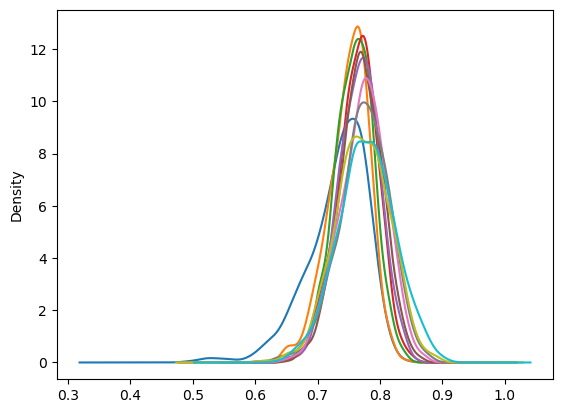

In [3]:

all_roc = []

for perc_finetune in np.arange(0.1, 1.1, .1):  #1.1

    ''' Load predProba'''
    model = 'rfc'
    with open(f'{resultsPath}/bootstrap_{round(perc_finetune,1)}_n{n_iter}_predProba.pickle', 'rb') as f:
        dic_proba = pickle.load(f)
    data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

    dic_performanceScores = {
        "roc_auc":np.array([]),
    }
    for run in range(data.shape[1]):
        predproba = data[run][data[run].notna()]
        tru = y_val.loc[predproba.index]   
        
        ## ROC AUC
        dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))

    df_scores = pd.DataFrame.from_dict(dic_performanceScores)
    all_roc.append(df_scores["roc_auc"].mean())
    print(round(perc_finetune,1), df_scores["roc_auc"].mean())
    df_scores["roc_auc"].plot.density(label=perc_finetune)

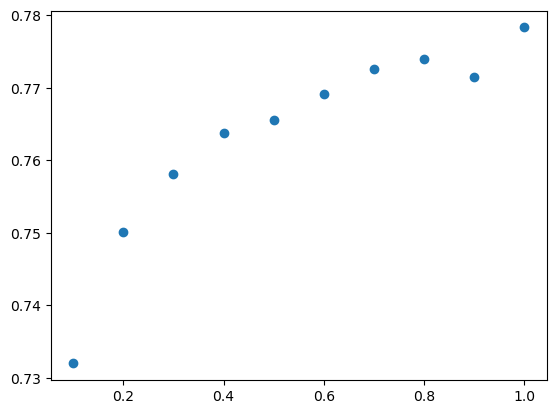

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(x=np.arange(0.1, 1.1, .1), y=all_roc)

In [12]:
all_roc

[0.731984660706718,
 0.7500683957007614,
 0.758177192641122,
 0.7638004169416588,
 0.7655894260704734,
 0.7691545653437215,
 0.7725638737378879,
 0.7739320088157505,
 0.7714957156940309,
 0.7783206752892272]

# Best percentage: 0.3

In [3]:

for perc_finetune in [0.3]: 

    ''' Load predProba'''
    model = 'rfc'
    with open(f'{resultsPath}/bootstrap_{round(perc_finetune,1)}_n{n_iter}_predProba.pickle', 'rb') as f:
        dic_proba = pickle.load(f)
    data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

    dic_performanceScores = {
        "acc":np.array([]),
        "prec":np.array([]),
        "recall":np.array([]),
        "f1-score":np.array([]),
        "brier":np.array([]),
        "roc_auc":np.array([]),
        "pr":np.array([]),
    }

    for run in range(data.shape[1]):
        predproba = data[run][data[run].notna()]
        pred = predproba.copy()
        pred[predproba < 0.5] = 0
        pred[predproba >= 0.5] = 1
        tru = y_val.loc[predproba.index]   
        
        ## Accuracy
        dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
        ## Precision
        dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
        ## Recall
        dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
        # F1-score
        dic_performanceScores["f1-score"] = np.append(dic_performanceScores["f1-score"],f1_score(tru, pred))
        ## Brier
        dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
        ## ROC AUC
        dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
        ## PR
        dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

    df_scores = pd.DataFrame.from_dict(dic_performanceScores)


## Calculate CI

In [7]:
""" 
Calculate confidence intervals 
"""
df_ci = pd.DataFrame()
for col in df_scores.columns:
    df_ci[col] = np.array([np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5)])
df_ci.index = ["mean", "lower_CI", "upper_CI"]

#### Save to file
## df_ci.to_csv(f"{resultsPath}/bootstrap_CI_95%.csv")

In [8]:
for i, col in enumerate(df_ci.columns):
    print(col)
    print("%.3f" % df_ci.iloc[0, i], "(%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("\n")

acc
0.677 (0.617, 0.737)


prec
0.644 (0.534, 0.776)


recall
0.568 (0.417, 0.726)


f1-score
0.598 (0.509, 0.682)


brier
0.199 (0.168, 0.238)


roc_auc
0.758 (0.697, 0.817)


pr
0.701 (0.604, 0.780)




# Check different decision cutoffs:


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:

''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_0.3_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

dic_all = {}
dic_all_CI_lower = {}
dic_all_CI_upper = {}




for cutoff in np.arange(0,1.1,0.1):
    print(cutoff)

    dic_cutoffScores = {
        "TN":np.array([]),
        "FP":np.array([]),
        "FN":np.array([]),
        "TP":np.array([]),
        # "TPR":np.array([]),
        # "TNR":np.array([]),
        "FPR":np.array([]),     ## probability/risk of over-treatment
        "FNR":np.array([]),     ## risk of under-treatment
    }

    for run in range(data.shape[1]):
        predproba = data[run][data[run].notna()]
        pred = predproba.copy()
        pred[predproba < cutoff] = 0
        pred[predproba >= cutoff] = 1
        tru = y_val.loc[predproba.index]   


        tn, fp, fn, tp = confusion_matrix(tru, pred, normalize="all").ravel()
        # tpr = tp/(tp+fn)
        # tnr = tn/(tn+fp)
        fpr = fp/(fp+tn)        # False Positives / (False Positives + True Negatives)
        fnr = fn/(fn+tp)        # False Negatives / (False Negatives + True Positives)

        dic_cutoffScores["TN"] = np.append(dic_cutoffScores["TN"],tn)
        dic_cutoffScores["FP"] = np.append(dic_cutoffScores["FP"],fp)
        dic_cutoffScores["FN"] = np.append(dic_cutoffScores["FN"],fn)
        dic_cutoffScores["TP"] = np.append(dic_cutoffScores["TP"],tp)
        # dic_cutoffScores["TPR"] = np.append(dic_cutoffScores["TPR"],tpr)
        # dic_cutoffScores["TNR"] = np.append(dic_cutoffScores["TNR"],tnr)
        dic_cutoffScores["FPR"] = np.append(dic_cutoffScores["FPR"],fpr)
        dic_cutoffScores["FNR"] = np.append(dic_cutoffScores["FNR"],fnr)

        df = pd.DataFrame.from_dict(dic_cutoffScores)

    tmp_lower = np.array([])
    tmp_upper = np.array([])
    for col in df.columns: 
        lower = np.percentile(df[col], 2.5) 
        upper = np.percentile(df[col], 97.5)
        tmp_lower = np.append(tmp_lower, lower)
        tmp_upper = np.append(tmp_upper, upper)       

    dic_all[cutoff] = df.mean().to_numpy()
    dic_all_CI_lower[cutoff] = tmp_lower
    dic_all_CI_upper[cutoff] = tmp_upper


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [16]:
df_mean = pd.DataFrame.from_dict(dic_all).T # *100
df_lower = pd.DataFrame.from_dict(dic_all_CI_lower).T #*100
df_upper = pd.DataFrame.from_dict(dic_all_CI_upper).T #*100

for ds in [df_mean, df_lower, df_upper]:
    ds.columns = dic_cutoffScores.keys()

In [26]:
# for rw in range(df_mean.shape[0]):
#     for i, col in enumerate(df_mean.columns[:4]):
#         print(rw, col, i)
#         print("%.0f" % df_mean.iloc[rw, i], "(%.0f," % df_lower.iloc[rw, i], "%.0f)" % df_upper.iloc[rw, i])
#         print("\n")


cc = 5
for rw in range(df_mean.shape[0]):
    for i, col in enumerate(df_mean.columns[cc:]):
        print(rw, col, i+cc)
        print("%.2f" % df_mean.iloc[rw, i+cc], "(%.2f," % df_lower.iloc[rw, i+cc], "%.2f)" % df_upper.iloc[rw, i+cc])
        print("\t")

0 FNR 5
0.00 (0.00, 0.00)
	
1 FNR 5
0.07 (0.00, 0.19)
	
2 FNR 5
0.15 (0.03, 0.31)
	
3 FNR 5
0.24 (0.10, 0.41)
	
4 FNR 5
0.33 (0.18, 0.50)
	
5 FNR 5
0.43 (0.27, 0.58)
	
6 FNR 5
0.54 (0.38, 0.69)
	
7 FNR 5
0.64 (0.48, 0.79)
	
8 FNR 5
0.75 (0.59, 0.90)
	
9 FNR 5
0.87 (0.71, 0.98)
	
10 FNR 5
1.00 (0.97, 1.00)
	


In [28]:
df_mean

,TN,FP,FN,TP,FPR,FNR
0.0,0.000000,0.604584,0.000000,0.395416,1.000000,0.000000
0.1,0.174647,0.429936,0.026780,0.368637,0.710907,0.067584
0.2,0.275799,0.328784,0.060015,0.335401,0.543579,0.151544
0.3,0.354225,0.250358,0.095624,0.299793,0.413873,0.241581
0.4,0.418908,0.185675,0.132374,0.263043,0.306917,0.334473
0.5,0.475585,0.128998,0.170893,0.224524,0.213201,0.431893
0.6,0.522443,0.082140,0.212490,0.182927,0.135721,0.537086
0.7,0.557780,0.046804,0.253981,0.141436,0.077317,0.641992
0.8,0.583096,0.021487,0.295894,0.099523,0.035492,0.748003
0.9,0.599046,0.005537,0.344359,0.051058,0.009150,0.870681


# Calibration curve

In [12]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_0.3_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [13]:
data = data.mean(axis=1).sort_index()
tru = y_val.loc[data.index] 

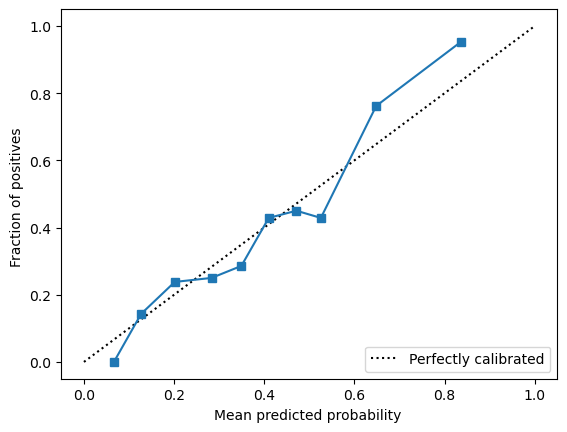

In [17]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

prob_true, prob_pred = calibration_curve(tru, data, n_bins=10,strategy="quantile")

CalibrationDisplay(prob_true, prob_pred, data).plot()

# Net benefit

In [3]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_0.3_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T


data = data.mean(axis=1).sort_index()
tru = y_val.loc[data.index] 

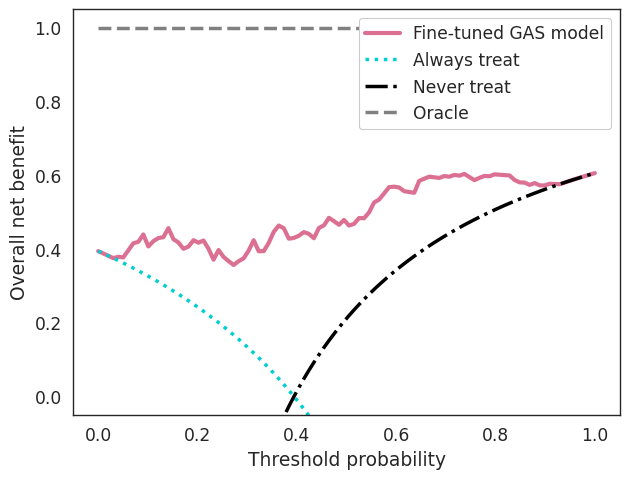

In [99]:
# b = data.T.mean().sort_index()
# c = y.loc[b.index]

sns.set_theme(style="white", font_scale=1.4, context="paper")#
fig, ax = plt.subplots(figsize=(6.5,5))
decision.NetBenefitDisplay.from_predictions(tru, data, name='fine-tuned model', ax=ax, benefit_type="overall")

ax.get_lines()[0].set_color('palevioletred')
ax.get_lines()[0].set_linewidth(3)

ax.get_lines()[2].set_color('black')
ax.get_lines()[3].set_color('gray')
ax.get_lines()[1].set_color('darkturquoise')
for i in range(1,len(ax.get_lines())): 
    ax.get_lines()[i].set_linewidth(2.5)

ax.legend(labels=["Fine-tuned GAS model", 
                  "Always treat", 
                  "Never treat",
                  "Oracle"], loc="upper right", facecolor='white', framealpha=1) #bbox_to_anchor=(1,1)

plt.tight_layout()
plt.savefig(f"{folderFigures}/netBenefitCurve.png")